In [3]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis

In [5]:
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)

Qubit(ROIF=0.10268999999999995, ef_ssm=-0.2568, ge_amp=0.795, qubit_thr=[-10000, -600], ro_dur=5000, RO_LO_pwr=16, ef_time=49, ge_ssm=-0.1144, RO_LO=6.6247, ge_time=82, qubit_id=q1, ef_amp=1.48, ro_amp=0.15, IQ_angle=110, RO_IF=None, ro_freq=6.72739)
Qubit(ROIF=0.030840000000000423, ef_ssm=-0.2962, ge_amp=0.8, qubit_thr=[-10000, 1900], ro_dur=5000, RO_LO_pwr=16, ef_time=None, ge_ssm=-0.154, RO_LO=6.6247, ge_time=55, qubit_id=q2, ef_amp=1, ro_amp=0.7, IQ_angle=25, RO_IF=None, ro_freq=6.65554)


In [6]:
def run_rabi_tomo(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    J: float,
    y_ph: int,
    amp: float 
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp_J=J,
        tomo_comp=tomography,
        y_ph=y_ph,
        amp=amp
    )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values

In [18]:
y_ph = 155
reps = 1000
sweep_time = 250
swap_freq = -0.0194
swap_time = 0.5 * 7 / abs(swap_freq)
J = 10
num_steps = 51
sweep_start=0
sweep_end=1.7
sweep_steps=51
sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)

# Define folders for plus and minus data (adjust folder names as needed)
tomo_x_folder = os.path.join("amp_sweep", "x")
tomo_y_folder = os.path.join("amp_sweep", "y")
os.makedirs(tomo_x_folder, exist_ok=True)
os.makedirs(tomo_y_folder, exist_ok=True)

# Initialize dictionaries for storing the loaded or computed data
return_x = {}   # for plus measurements
return_y = {}   # for minus measurements

# Optionally, if you want to keep track of the data in lists/arrays:
sweep_data_x = {}
sweep_data_y = {}

# Loop over sweep values (e.g., different pi_phase values)
for i, sweep_val in enumerate(sweep_vals):
    # Build filenames using the sweep value as part of the name
    x_filename = os.path.join(tomo_x_folder, f"amp={sweep_val:.5f}.pkl")
    y_filename = os.path.join(tomo_y_folder, f"amp={sweep_val:.5f}.pkl")
    
    # If both files exist, load them and store in the dictionaries
    if os.path.exists(x_filename ) and os.path.exists(y_filename):
        with open(x_filename , "rb") as f:
            x_data = pickle.load(f)
        with open(y_filename, "rb") as f:
            y_data = pickle.load(f)
        return_x[sweep_val] = x_data
        return_x[sweep_val] = y_data
        continue  # Skip to the next sweep value if files exist

    # Otherwise, perform the measurement:
    amp = sweep_val  # Set the current amplitude for the measurement       
    tomography_x = "x"
    tomography_y = "y"
    # Perform the measurements for tomography "x" and "y"
    df_prob_x, df_pop_x, values_x = run_rabi_tomo(
        q1=q1,
        q2=q2,
        general_vals_dict=general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        reps=reps,
        tomography=tomography_x,
        J=J,
        y_ph=y_ph,
        amp=amp
    )
    df_prob_y, df_pop_y, values_y = run_rabi_tomo(
        q1=q1,
        q2=q2,
        general_vals_dict=general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        reps=reps,
        tomography=tomography_y,
        J=J,
        y_ph=y_ph,
        amp=amp
    )
    
    # Save the measurement results to their respective pickle files
    with open(x_filename, "wb") as f:
        pickle.dump(df_prob_x, f)
    with open(y_filename, "wb") as f:
        pickle.dump(df_prob_y, f)
    
    # Populate the dictionaries with the results, keyed by the amplitude value
    return_x[sweep_val] = df_prob_x
    return_y[sweep_val] = df_prob_y

print("Measurement complete!")




writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 1000
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.913867 sec
Captured 17 buffers (2.458826 buffers per sec)
Captured 52224 records (7553.514758 records per sec)
Transferred 855638016 bytes (123756785.802866 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error


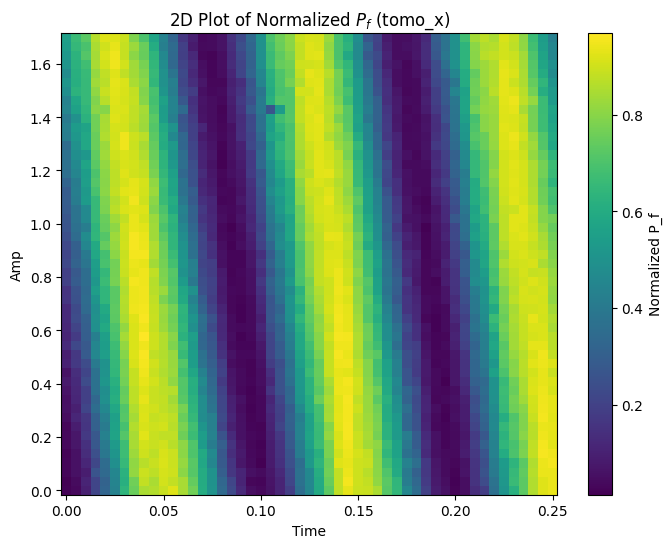

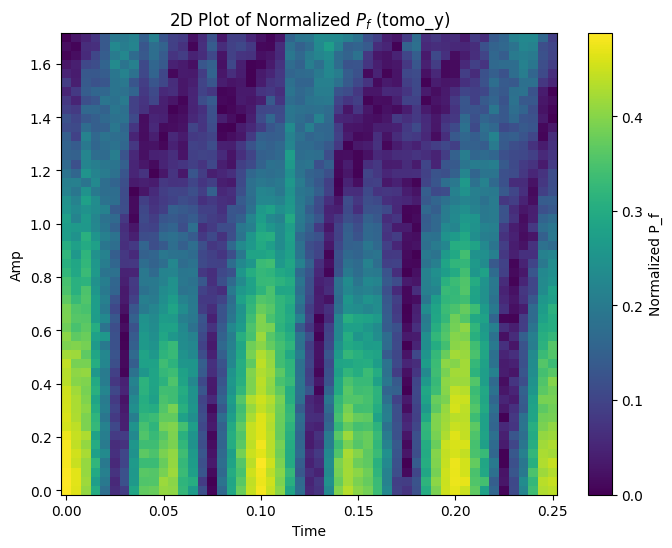

In [ ]:
# Folders where the pickle files are stored
tomo_x_folder = os.path.join("amp_sweep", "x")
tomo_y_folder = os.path.join("amp_sweep", "y")

# Function to extract the amplitude (sweep value) from the filename
def get_amp_from_filename(filename):
    # Assumes filename format "amp={value}.pkl"
    base = os.path.basename(filename)
    base_no_ext = os.path.splitext(base)[0]  # e.g., "amp=1.23456"
    try:
        amp_str = base_no_ext.split('=')[1]
        return float(amp_str)
    except (IndexError, ValueError):
        return None

# Get sorted list of pickle files based on the amplitude value
x_files = sorted(
    [os.path.join(tomo_x_folder, f) for f in os.listdir(tomo_x_folder) if f.endswith('.pkl')],
    key=get_amp_from_filename
)
y_files = sorted(
    [os.path.join(tomo_y_folder, f) for f in os.listdir(tomo_y_folder) if f.endswith('.pkl')],
    key=get_amp_from_filename
)

# Lists to store amplitude values and the corresponding normalized P_f arrays for x
amps_x = []
norm_Pf_x_list = []
time_array = None  # Will be taken from the first file

for file in x_files:
    amp = get_amp_from_filename(file)
    if amp is None:
        continue
    amps_x.append(amp)
    with open(file, "rb") as f:
        # Each pickle file is assumed to contain a DataFrame
        df = pickle.load(f)
    # Normalize P_f as: P_f_norm = P_f / (P_f + P_e)
    # (Assuming your DataFrame has columns "P_f" and "P_e" and a column "time")
    df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
    # Save the normalized data (as a numpy array) for each sweep value (row)
    norm_Pf_x_list.append(df["normalized_P_f"].values)
    if time_array is None:
        # Use the 'time' column if available; otherwise, use the index
        if "time" in df.columns:
            time_array = df["time"].values
        else:
            time_array = df.index.values

# Convert to numpy array (shape: [n_amp, n_time])
norm_Pf_x = np.array(norm_Pf_x_list)
amps_x = np.array(amps_x)

# Repeat the same for the y data
amps_y = []
norm_Pf_y_list = []

for file in y_files:
    amp = get_amp_from_filename(file)
    if amp is None:
        continue
    amps_y.append(amp)
    with open(file, "rb") as f:
        df = pickle.load(f)
    df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
    norm_Pf_y_list.append(df["normalized_P_f"].values)

norm_Pf_y = np.array(norm_Pf_y_list)
amps_y = np.array(amps_y)

# Create a 2D plot for df_prob_x
plt.figure(figsize=(8, 6))
# pcolormesh expects X and Y coordinates. Here, time_array is along x and amplitude along y.
plt.pcolormesh(time_array, amps_x, norm_Pf_x, shading='auto')
plt.colorbar(label='Normalized P_f')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.title('2D Plot of Normalized $P_f$ (tomo_x)')
plt.show()

# Create a 2D plot for df_prob_y
plt.figure(figsize=(8, 6))
plt.pcolormesh(time_array, amps_y, norm_Pf_y, shading='auto')
plt.colorbar(label='Normalized P_f')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.title('2D Plot of Normalized $P_f$ (tomo_y)')
plt.show()

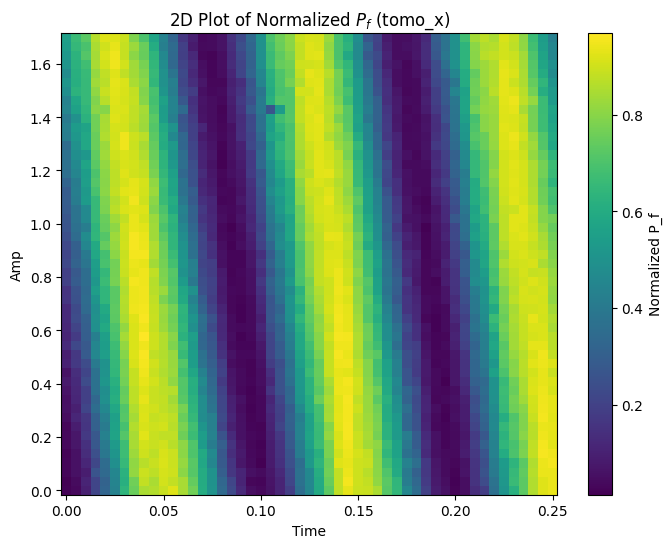

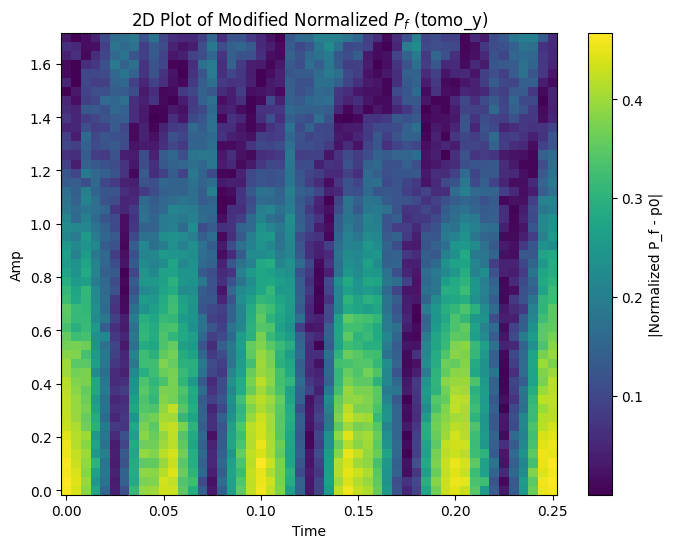

In [24]:
# Process tomo_x data
amps_x = []
norm_Pf_x_list = []
time_array = None  # Will be taken from the first file

for file in x_files:
    amp = get_amp_from_filename(file)
    if amp is None:
        continue
    amps_x.append(amp)
    with open(file, "rb") as f:
        # Each pickle file is assumed to contain a DataFrame
        df = pickle.load(f)
    # Normalize P_f as: P_f_norm = P_f / (P_f + P_e)
    df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
    norm_Pf_x_list.append(df["normalized_P_f"].values)
    if time_array is None:
        # Use the 'time' column if available; otherwise, use the index
        if "time" in df.columns:
            time_array = df["time"].values
        else:
            time_array = df.index.values

norm_Pf_x = np.array(norm_Pf_x_list)
amps_x = np.array(amps_x)

# Process tomo_y data with modified normalization
amps_y = []
norm_Pf_y_list = []

for file in y_files:
    amp = get_amp_from_filename(file)
    if amp is None:
        continue
    amps_y.append(amp)
    with open(file, "rb") as f:
        df = pickle.load(f)
    # Normalize P_f as: P_f_norm = P_f / (P_f + P_e)
    df["normalized_P_f"] = df["P_f"] / (df["P_f"] + df["P_e"])
    # Compute p0 as the average of the maximum and minimum normalized_P_f values
    p0 = (df["normalized_P_f"].max() + df["normalized_P_f"].min()) / 2.0
    # Replace normalized_P_f with its absolute deviation from p0
    df["normalized_P_f"] = abs(df["normalized_P_f"] - p0)
    norm_Pf_y_list.append(df["normalized_P_f"].values)

norm_Pf_y = np.array(norm_Pf_y_list)
amps_y = np.array(amps_y)

# Create a 2D plot for tomo_x data
plt.figure(figsize=(8, 6))
plt.pcolormesh(time_array, amps_x, norm_Pf_x, shading='auto')
plt.colorbar(label='Normalized P_f')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.title('2D Plot of Normalized $P_f$ (tomo_x)')
plt.show()

# Create a 2D plot for modified tomo_y data
plt.figure(figsize=(8, 6))
plt.pcolormesh(time_array, amps_y, norm_Pf_y, shading='auto')
plt.colorbar(label='|Normalized P_f - p0|')
plt.xlabel('Time')
plt.ylabel('Amp')
plt.title('2D Plot of Modified Normalized $P_f$ (tomo_y)')
plt.show()

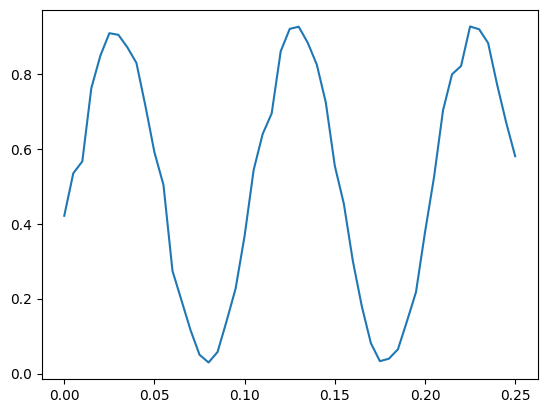

In [26]:
plt.plot(time_array,norm_Pf_x[40])